In [1]:
from fore_utils import *

In [2]:
import torch
import torch.nn as nn
    
class TransformerModel(nn.Module):
    def __init__(self, window_size: int = 24, variables: int = 6, spaces: int = 0, d_model=64, nhead=8, num_layers=8, output_dim: int = 12):
        super(TransformerModel, self).__init__()

        input_dim = window_size * variables * spaces

        self.encoder = nn.Linear(input_dim, d_model)

        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)

        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        # print(x.shape)

        x = self.encoder(x)
        # print(x.shape)

        x = x.unsqueeze(1) 
        
        x = self.transformer_encoder(x)
        # print(x.shape)

        x = self.decoder(x.squeeze(1))
        # print(x.shape)
        
        return x


In [24]:
window_size = 5
steps = 24
spaces = 4
hidden_size = 32
batch_size = 64
n_heads = 4
num_layers = 8
series_target = True
lightning = True
verbose = True

config = {
    "hidden_layer_sizes": [hidden_size],
    "window_size" : [window_size],
    "step_size" : [steps],
    "spaces" : [spaces],
    "batch_size": [batch_size],
    "n_heads": [n_heads],
    "num_layers": [num_layers],
    "series_target": [series_target],
    "lightning": [lightning],
}

train_set = WeatherData(window_size=window_size, step_size=steps, set='train', spaces=spaces, lightning=lightning, series_target=series_target, verbose=verbose)
train_loader = DataLoader(train_set,
                           batch_size=batch_size, shuffle=True)
    
val_set = WeatherData(window_size=window_size, step_size=steps, set='val', spaces=spaces, lightning=lightning, series_target=series_target, verbose=verbose)
val_loader = DataLoader(val_set,
                           batch_size=batch_size, shuffle=False)


Details for train set:
Data from ['2018', '2019', '2020', '2021'] loaded
Features shape: torch.Size([35064, 4, 4, 5])
Targets shape: torch.Size([35064])
Longitudes: [17.80613  18.056143 18.306158 18.556171]
Latitudes: [-31.137 -31.387 -31.637 -31.887]
Details for val set:
Data from ['2022'] loaded
Features shape: torch.Size([8760, 4, 4, 5])
Targets shape: torch.Size([8760])
Longitudes: [17.80613  18.056143 18.306158 18.556171]
Latitudes: [-31.137 -31.387 -31.637 -31.887]


Input shape: torch.Size([64, 5, 4, 4, 5])
Target shape: torch.Size([64, 12])
Prediction shape: torch.Size([64, 12])
torch.Size([64, 5])


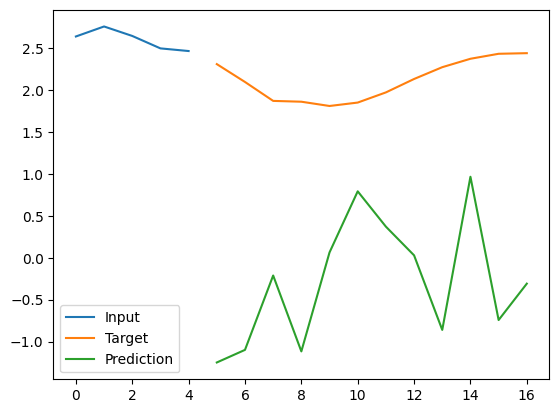

In [25]:
for batch in train_loader:
    x,b, y = batch
    break

model = TransformerModel(window_size=window_size, 
                            variables=5, 
                            spaces=16, 
                            d_model=hidden_size, 
                            nhead=n_heads, 
                            num_layers=num_layers, 
                            output_dim=steps)

model.to('cpu')

y_pred = model(x.float())

print('Input shape:', x.shape)
print('Target shape:', y.shape)
print('Prediction shape:', y_pred.shape)

print(b.shape)

plt.plot(np.arange(window_size), b[0].detach().numpy(), label='Input')
plt.plot(np.arange(window_size,window_size+steps), y[0].detach().numpy(),  label='Target')
plt.plot(np.arange(window_size,window_size+steps), y_pred[0].detach().numpy(), label='Prediction')

plt.legend()
plt.show()

In [26]:
# Hyperparameters
n_epochs = 100
warmup_epochs = 10
initial_lr = 1e-5
early_stopping_patience = 5
checkpoint_path = f'best_model_{window_size}_{hidden_size}_{steps}_{n_heads}_{num_layers}_spatial.pth'

wandb.init(project="time_series_forecasting", name=f'model_{window_size}_{hidden_size}_{steps}_spatial', config=config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
                         
train_model(model, train_loader, val_loader, n_epochs=n_epochs, warmup_epochs=warmup_epochs,
            initial_lr=initial_lr, early_stopping_patience=early_stopping_patience, checkpoint_path=checkpoint_path, device=device)



Epoch 0, Batch 0, Loss: 2.9161
Epoch 0, Batch 100, Loss: 1.8788
Epoch 0, Batch 200, Loss: 1.4644
Epoch 0, Batch 300, Loss: 1.2122
Epoch 0, Batch 400, Loss: 0.9188
Epoch 0, Batch 500, Loss: 0.7886
Epoch 0 Completed, Average Training Loss: 1.4406
Validation Loss after Epoch 0: 0.7573
Learning rate after Epoch 0: 0.000002
New best model saved with validation loss: 0.7573
Epoch 1, Batch 0, Loss: 0.6490
Epoch 1, Batch 100, Loss: 0.8276
Epoch 1, Batch 200, Loss: 0.7525
Epoch 1, Batch 300, Loss: 0.4188
Epoch 1, Batch 400, Loss: 0.5171
Epoch 1, Batch 500, Loss: 0.5507
Epoch 1 Completed, Average Training Loss: 0.6128
Validation Loss after Epoch 1: 0.5512
Learning rate after Epoch 1: 0.000003
New best model saved with validation loss: 0.5512
Epoch 2, Batch 0, Loss: 0.4367
Epoch 2, Batch 100, Loss: 0.4605
Epoch 2, Batch 200, Loss: 0.5463
Epoch 2, Batch 300, Loss: 0.5602
Epoch 2, Batch 400, Loss: 0.3964
Epoch 2, Batch 500, Loss: 0.5010
Epoch 2 Completed, Average Training Loss: 0.5314
Validation Lo

In [27]:
test_loader = DataLoader(WeatherData(window_size=window_size, step_size=steps, set='test', spaces=spaces, lightning=lightning, series_target=series_target, verbose=verbose),
                            batch_size=batch_size, shuffle=False)

model.load_state_dict(torch.load(checkpoint_path))
model.eval()

model.to(device)

test_loss = evaluate_model(model, test_loader, device)

print(f"Test loss: {test_loss}")

wandb.log({"test_loss": test_loss})

wandb.finish()

Details for test set:
Data from ['2023'] loaded
Features shape: torch.Size([8760, 4, 4, 5])
Targets shape: torch.Size([8760])
Longitudes: [17.80613  18.056143 18.306158 18.556171]
Latitudes: [-31.137 -31.387 -31.637 -31.887]
Test loss: 0.1803459446659706


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇████
learning_rate,▂▂▃▄▆█████████████████████████▄▄▄▄▂▂▂▂▁▁
test_loss,▁
train_loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,66
learning_rate,0.0
test_loss,0.18035
train_loss,0.14677
val_loss,0.16753


Input shape: torch.Size([64, 5, 4, 4, 5])
Target shape: torch.Size([64, 12])
Prediction shape: torch.Size([64, 12])


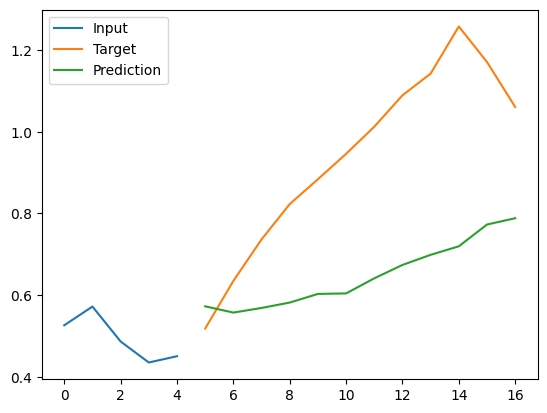

In [38]:
for batch in train_loader:
    x,b, y = batch
    break

model.to('cpu')

y_pred = model(x.float())

print('Input shape:', x.shape)
print('Target shape:', y.shape)
print('Prediction shape:', y_pred.shape)

plt.plot(np.arange(window_size), b[0].detach().numpy(), label='Input')
plt.plot(np.arange(window_size,window_size+steps), y[0].detach().numpy(),  label='Target')
plt.plot(np.arange(window_size,window_size+steps), y_pred[0].detach().numpy(), label='Prediction')

plt.legend()
plt.show()